***1. Importing libraries and loading data***

In [3]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# loading the dataset
df = pd.read_csv('/kaggle/input/formula-1-world-championship-1950-2020/lap_times.csv')

#displaying basic info
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 589081 entries, 0 to 589080
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   raceId        589081 non-null  int64 
 1   driverId      589081 non-null  int64 
 2   lap           589081 non-null  int64 
 3   position      589081 non-null  int64 
 4   time          589081 non-null  object
 5   milliseconds  589081 non-null  int64 
dtypes: int64(5), object(1)
memory usage: 27.0+ MB


,raceId,driverId,lap,position,time,milliseconds
0,841,20,1,1,1:38.109,98109
1,841,20,2,1,1:33.006,93006
2,841,20,3,1,1:32.713,92713
3,841,20,4,1,1:32.803,92803
4,841,20,5,1,1:32.342,92342


***2. Understanding Data***

In [4]:
# Display first 10 rows
df.head(10)

# Quick summary statistics for numeric columns
df.describe()

,raceId,driverId,lap,position,milliseconds
count,589081.000000,589081.000000,589081.000000,589081.000000,5.890810e+05
mean,600.544465,325.796446,30.018104,9.661951,9.579945e+04
std,434.375976,387.561736,18.407126,5.528553,7.639973e+04
min,1.000000,1.000000,1.000000,1.000000,5.540400e+04
25%,140.000000,16.000000,14.000000,5.000000,8.204100e+04
50%,861.000000,48.000000,29.000000,9.000000,9.060800e+04
75%,1003.000000,822.000000,44.000000,14.000000,1.019300e+05
max,1144.000000,862.000000,87.000000,24.000000,7.507547e+06


***3. Cleaning dataset***

In [5]:
# Check which columns are unique for every row
unique_cols = [col for col in df.columns if df[col].is_unique]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 589081 entries, 0 to 589080
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   raceId        589081 non-null  int64 
 1   driverId      589081 non-null  int64 
 2   lap           589081 non-null  int64 
 3   position      589081 non-null  int64 
 4   time          589081 non-null  object
 5   milliseconds  589081 non-null  int64 
dtypes: int64(5), object(1)
memory usage: 27.0+ MB


In [6]:
# No unique columns are found, therefore; we don't need to drop anything with unique values
# We'll have to drop time column, as it's irrelevant for the markov model
df = df.drop(columns=['time'])
print("Columns after dropping unnecessary ones:")
df.info()

Columns after dropping unnecessary ones:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 589081 entries, 0 to 589080
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype
---  ------        --------------   -----
 0   raceId        589081 non-null  int64
 1   driverId      589081 non-null  int64
 2   lap           589081 non-null  int64
 3   position      589081 non-null  int64
 4   milliseconds  589081 non-null  int64
dtypes: int64(5)
memory usage: 22.5 MB


In [7]:
# dropping any missing rows
df = df.dropna()

# converting lap and position to integers
df['lap'] = df['lap'].astype(int)
df['position'] = df['position'].astype(int)

# printing the Dimensions (Size) of the dataframe and basic data
print("Shape of dataset:", df.shape)
print("Columns:", df.columns.tolist())
df.head()


Shape of dataset: (589081, 5)
Columns: ['raceId', 'driverId', 'lap', 'position', 'milliseconds']


,raceId,driverId,lap,position,milliseconds
0,841,20,1,1,98109
1,841,20,2,1,93006
2,841,20,3,1,92713
3,841,20,4,1,92803
4,841,20,5,1,92342


In [8]:
#Discretizing driver positions into tiers
# This reduces the number of states for the Markov model, making it more manageable
def position_tier(pos):
    if pos <= 3:
        return 'Podium'      # 1st, 2nd, 3rd place
    elif pos <= 10:
        return 'Top10'       # 4th to 10th place
    else:
        return 'Others'      # 11th place and beyond

# Apply the function to create a new column
df['Position_Tier'] = df['position'].apply(position_tier)

# Check the distribution of tiers
print("Distribution of Position Tiers in the full dataset:")
print(df['Position_Tier'].value_counts())

# Preview first 20 rows
df.head(20)


Distribution of Position Tiers in the full dataset:
Position_Tier
Others    259111
Top10     230389
Podium     99581
Name: count, dtype: int64


,raceId,driverId,lap,position,milliseconds,Position_Tier
0,841,20,1,1,98109,Podium
1,841,20,2,1,93006,Podium
2,841,20,3,1,92713,Podium
3,841,20,4,1,92803,Podium
4,841,20,5,1,92342,Podium
5,841,20,6,1,92605,Podium
6,841,20,7,1,92502,Podium
7,841,20,8,1,92537,Podium
8,841,20,9,1,93240,Podium
9,841,20,10,1,92572,Podium


***4. Sample a subset of races for the Markov model***

In [9]:
# 1. Create a Sampling function
import numpy as np

def sample_races(df, n=15, random_state=42):
    """
    Randomly select a subset of races from the dataset.
    Purpose: Reduce computation time and avoid overfitting by not analyzing every race at once.
    - n: number of races to sample
    - random_state: ensures reproducibility of the sampled races
    """
    # Create a random generator for reproducibility
    rng = np.random.default_rng(random_state) 

    # Get all unique race IDs
    race_ids = df['raceId'].drop_duplicates().to_numpy() 

    # Ensure we don't sample more races than exist
    n = min(n, len(race_ids))

    # Randomly pick 'n' races
    sample_ids = rng.choice(race_ids, size=n, replace=False)
    
    # Filter the dataframe for the sampled races and sort by race, driver, lap for clarity
    return df[df['raceId'].isin(sample_ids)].sort_values(by=['raceId','driverId','lap']).reset_index(drop=True)
    
# 2. Apply Sampling Function

# Get 15 random races
df_sample = sample_races(df, n=15)  
# Check which races were sampled
print(f"Sampled race IDs: {df_sample['raceId'].unique()}") 

# 3. Pick one full race to apply to Markov Model

# Pick one race at random from the sampled races to avoid bias
race_id = np.random.choice(df_sample['raceId'].unique())
df_race = df_sample[df_sample['raceId'] == race_id].sort_values(by=['driverId','lap']).reset_index(drop=True)
print(f"Building Markov model for race ID: {race_id}")

# 4. Preview Race Data

# Sort the race data by driverId and lap to ensure correct lap order for Markov transitions
df_race = df_race.sort_values(by=['driverId', 'lap']).reset_index(drop=True)

# Show all drivers' first laps to see starting positions and ensure we have multiple drivers
first_laps = df_race[df_race['lap'] == 1]
print("\nFirst lap positions for all drivers in this race:")
print(first_laps[['driverId', 'lap', 'position', 'Position_Tier']])

# Randomly sample 20 rows to see a mix of drivers and laps, for further understanding of the code
print("\nRandom sample of 20 rows from the race for overview:")
print(df_race.sample(20)[['driverId', 'lap', 'position', 'Position_Tier']])

# 5. Select one random driver from the chosen race to build an individual Markov model
driver_id = np.random.choice(df_race['driverId'].unique())
df_driver = df_race[df_race['driverId'] == driver_id].reset_index(drop=True)
print(f"\nBuilding Markov model for driver ID: {driver_id}")


Sampled race IDs: [  36   92   94  235  349  887  888  892  968  984  992 1004 1007 1057
 1128]
Building Markov model for race ID: 235

First lap positions for all drivers in this race:
     driverId  lap  position Position_Tier
0          14    1         9         Top10
23         22    1        10         Top10
98         30    1         1        Podium
168        35    1         2        Podium
245        44    1        14        Others
321        49    1        11        Others
371        50    1        15        Others
381        55    1         3        Podium
458        56    1         5         Top10
489        57    1         7         Top10
565        64    1        19        Others
566        65    1         8         Top10
601        71    1         4         Top10
678        73    1        16        Others
752        77    1         6         Top10
816        79    1        13        Others
890        83    1        18        Others
914        84    1        12        Othe

***5. Building Markov model and applying it on a randomly generated racer ID and using the Position Tier as a Transition Node***

In [10]:
import pandas as pd
import numpy as np

# Choose a random driver from the current race
driver_id = np.random.choice(df_race['driverId'].unique())
df_driver = df_race[df_race['driverId'] == driver_id].reset_index(drop=True)
print(f"Building Markov model for random driver ID: {driver_id}")

# Build the Markov model dictionary
markov_model = {}

# Count transitions for this driver
driver_sequence = df_driver.sort_values('lap')['Position_Tier'].tolist()
for i in range(len(driver_sequence)-1):
    curr_state = driver_sequence[i]
    next_state = driver_sequence[i+1]
    if curr_state not in markov_model:
        markov_model[curr_state] = {next_state: 1}
    else:
        if next_state in markov_model[curr_state]:
            markov_model[curr_state][next_state] += 1
        else:
            markov_model[curr_state][next_state] = 1

# Normalize counts to probabilities
for curr_state, transitions in markov_model.items():
    total = sum(transitions.values())
    for state in transitions:
        transitions[state] /= total

# Simulate a sequence starting from first lap
predicted_sequence = [driver_sequence[0]]
for _ in range(len(driver_sequence)-1):
    curr = predicted_sequence[-1]
    next_states = list(markov_model[curr].keys())
    probabilities = list(markov_model[curr].values())
    next_state = np.random.choice(next_states, p=probabilities)
    predicted_sequence.append(next_state)

print(predicted_sequence)


Building Markov model for random driver ID: 77
['Top10', 'Top10', 'Top10', 'Top10', 'Top10', 'Top10', 'Top10', 'Top10', 'Top10', 'Top10', 'Top10', 'Top10', 'Top10', 'Top10', 'Top10', 'Top10', 'Top10', 'Top10', 'Top10', 'Top10', 'Top10', 'Top10', 'Top10', 'Top10', 'Top10', 'Top10', 'Top10', 'Top10', 'Top10', 'Top10', 'Top10', 'Top10', 'Top10', 'Top10', 'Top10', 'Top10', 'Top10', 'Top10', 'Top10', 'Top10', 'Top10', 'Top10', 'Top10', 'Top10', 'Top10', 'Top10', 'Top10', 'Top10', 'Top10', 'Top10', 'Top10', 'Top10', 'Top10', 'Top10', 'Top10', 'Top10', 'Top10', 'Top10', 'Top10', 'Top10', 'Top10', 'Top10', 'Top10', 'Top10']


***6. Data Visualization using Heatmap Index***

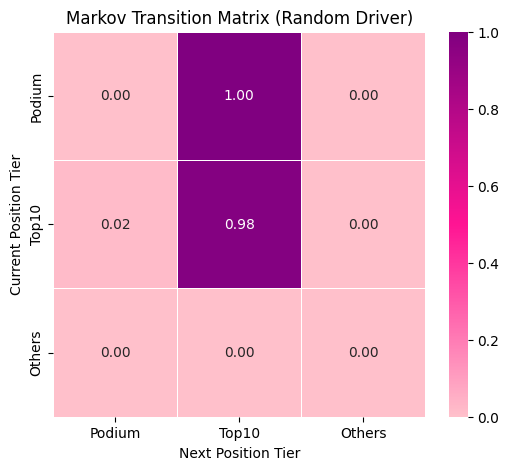

In [11]:
import numpy as np

# Define all possible tiers
all_states = ['Podium', 'Top10', 'Others']

# Build full matrix with all states
matrix = np.zeros((len(all_states), len(all_states)))

for i, curr in enumerate(all_states):
    for j, nxt in enumerate(all_states):
        matrix[i, j] = markov_model.get(curr, {}).get(nxt, 0)

plt.figure(figsize=(6,5))

# Custom colormap
import matplotlib.colors as mcolors
cmap = mcolors.LinearSegmentedColormap.from_list("", ["#FFC0CB", "#FF1493", "#800080"])

sns.heatmap(matrix, annot=True, fmt=".2f", xticklabels=all_states, yticklabels=all_states,
            cmap=cmap, cbar=True, linewidths=0.5)
plt.xlabel("Next Position Tier")
plt.ylabel("Current Position Tier")
plt.title("Markov Transition Matrix (Random Driver)")
plt.show()
